### Student Information
Name: 郭沅昕

Student ID: 108011570

GitHub ID: Jerrykuo2019

Kaggle name: Jerry Kuo

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM19-Lab2-Master Repo](https://github.com/EvaArevalo/DM19-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/179d01d4dd984fc5ac45a894822479dd) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the score (ie. 20% of 30% )

    - **Top 41% - 100%**: Get (101-x)% of the score, where x is your ranking in the leaderboard (ie. (101-x)% of 30% )   
    Submit your last submission __BEFORE the deadline (Nov. 23rd 11:59 pm, Saturday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/EvaArevalo/DM19-Lab1-Master/blob/master/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb), but make sure to fork the [DM19-Lab2-Homework](https://github.com/EvaArevalo/DM19-Lab2-Homework) repository this time! Also please __DON´T UPLOAD HUGE DOCUMENTS__, please use Git ignore for that.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th 11:59 pm, Tuesday)__. 

In [2]:
### Begin Assignment Here

---
---
# First part：take home exercises
---
---

## Some necessary cell for take home exercise

In [41]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import ReLU, Softmax
from tensorflow.keras.callbacks import CSVLogger

from gensim.models import KeyedVectors

from sklearn.manifold import TSNE

In [ ]:
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [5]:
## load a pickle file
train_df = pd.read_pickle("data/train_df.pkl")
test_df = pd.read_pickle("data/test_df.pkl")

In [21]:
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

C:\Users\user\Anaconda3\envs\deep\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [35]:
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

In [36]:

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

# I/O check
input_shape = X_train.shape[1]
output_shape = len(label_encoder.classes_)


# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)
model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 10
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')
# %%

## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")

check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1704       fear
1152       fear
1038       fear
3497    sadness
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32064     
_________________________________________________________________
re_lu_4 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
______________________

,epoch,acc,loss,val_acc,val_loss
0,0,0.372544,1.321301,0.403458,1.289665
1,1,0.646554,0.975627,0.654179,0.923945
2,2,0.806809,0.566070,0.685879,0.793337
3,3,0.858566,0.397965,0.700288,0.781795
4,4,0.893994,0.305600,0.691643,0.787536
5,5,0.915583,0.243863,0.694524,0.884635
6,6,0.935511,0.201842,0.691643,0.952732
7,7,0.949903,0.167935,0.694524,1.009574
8,8,0.956269,0.145829,0.688761,1.051553
9,9,0.962912,0.126164,0.685879,1.088726


---
---

---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)

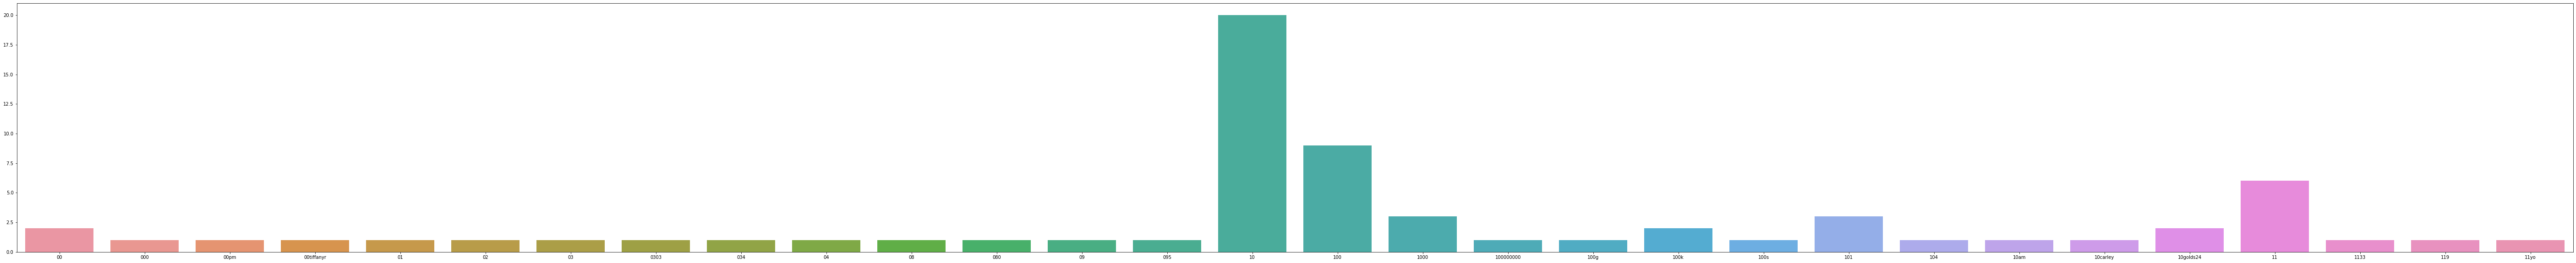

In [11]:
count_vect = CountVectorizer()

train_counts = count_vect.fit_transform(train_df.text)
feature_names = count_vect.get_feature_names()

term_frequencies = []
for j in range(0,train_counts.shape[1]):
    term_frequencies.append(sum(train_counts[:,j].toarray()))

# plot
list1=[]
for i in range(30):
     list1=list1+[term_frequencies[i][0]]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names()[:30], 
            y=list1[:30])

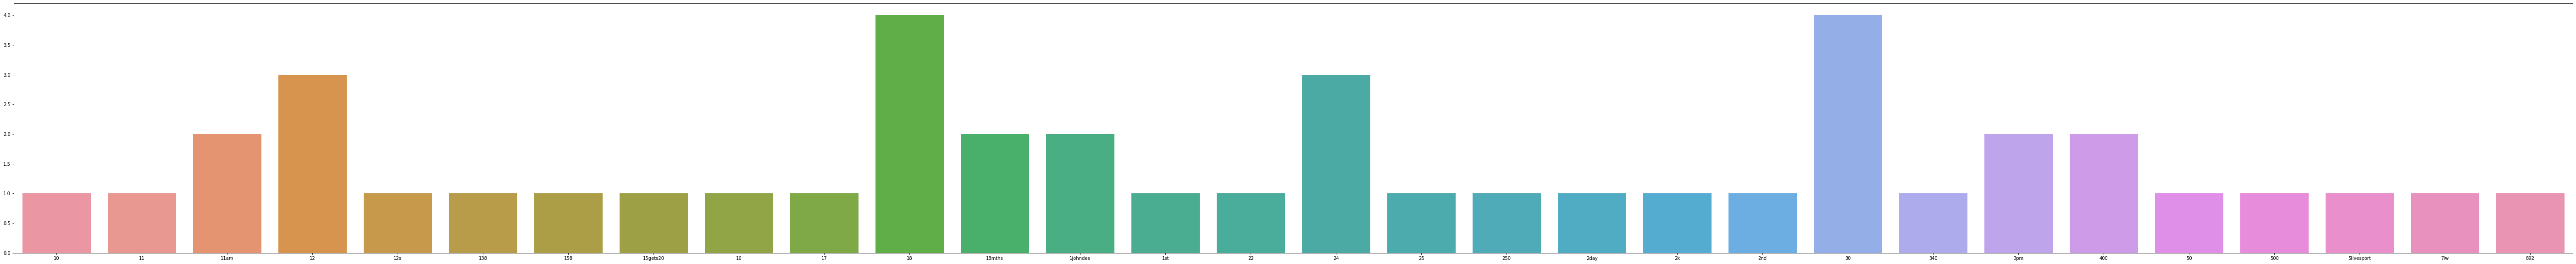

In [12]:
test_counts = count_vect.fit_transform(test_df.text)
feature_names = count_vect.get_feature_names()

term_frequencies = []
for j in range(0,test_counts.shape[1]):
    term_frequencies.append(sum(test_counts[:,j].toarray()))

list1=[]
for i in range(30):
     list1=list1+[term_frequencies[i][0]]
plt.subplots(figsize=(100, 10))

g = sns.barplot(x=count_vect.get_feature_names()[:30], 
            y=list1[:30])

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [17]:
tfidf_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)

tfidf_1000.fit(train_df['text'])
train_data_tfidf_features = tfidf_1000.transform(train_df['text'])

feature_names = tfidf_1000.get_feature_names()
feature_names[100:110]

C:\Users\user\Anaconda3\envs\deep\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc', 'bday']

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

    Confusion matrix：
        Present the relationship between predicted label and true label, for the example, there are 55 samples that the model predited them to 'anger' and those sample are really 'anger'. More example, there are 16 samples that belong to 'fear', but the model prdict them to 'anger'. We hope our model can get a confusion matrix, that only the diagonal has values, and the rest are zero.
        
    Recall = TP/(TP+FN)
        Recall is the ratio of correctly predicted positive observations to the all observations in actual class.
        
    Precision = TP/(TP+FP)
        Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
        
    F1-score = 2 * Precision * Recall / (Precision + Recall)
        F1 Score is the weighted average of Precision and Recall.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [23]:
MNB_model = MultinomialNB()

MNB_model = MNB_model.fit(X_train, y_train)

## predict!
y_train_pred = MNB_model.predict(X_train)
y_test_pred = MNB_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

## accuracy

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

## precision, recall, f1-score,

print(classification_report(y_true=y_test, y_pred=y_test_pred))

## check by confusion matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

training accuracy: 0.79
testing accuracy: 0.72
              precision    recall  f1-score   support

       anger       0.71      0.65      0.68        84
        fear       0.74      0.83      0.78       110
         joy       0.76      0.71      0.73        79
     sadness       0.65      0.64      0.64        74

    accuracy                           0.72       347
   macro avg       0.71      0.71      0.71       347
weighted avg       0.72      0.72      0.72       347

[[55 14  5 10]
 [ 6 91  5  8]
 [ 9  7 56  7]
 [ 8 11  8 47]]


---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

        The result of Decision Tree model is overfitting, that means model prefectly fit the training data so it will get high accuracy on training data, but get the worse accuracy on training data.
        Naive Bayes model can not even fit the training data to 80% accuracy, but it get a better performance than Decision Tree model.
        We can explain this phenomenon by using variance and bias. Decision Tree has small bias and big variance, so this model has a chance to get 99% accuracy on Training data, but the big variance let Decision Tree get a worse accuracy on testing data. In contrast, althought Naive Bayes could not fit training data perfectly, but it has smaller variance, so in the result, Naive Bayes model get higher accuracy than Decision Tree on testing data, even it couldn't fit the training data so well.
    

---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below (Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

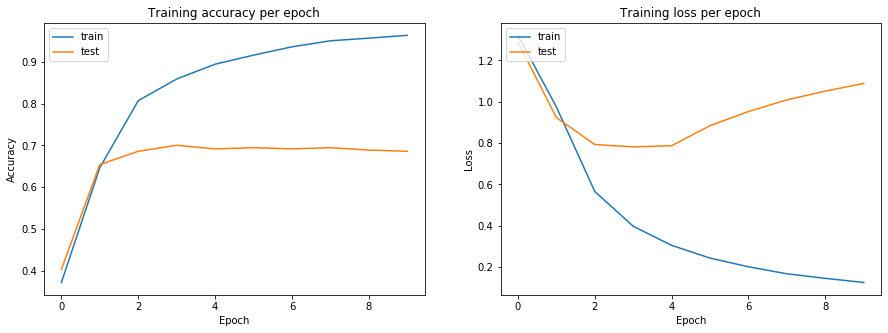

In [37]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.show()

        At the eighth epoch the training accuracy is 96%, but the testing accuracy only got 68%, it show that the model only fit the training data, but did not fit testing data, that we call the model is overfitting. We can also find out the model is overfitting from observed by the training loss graph, in the loss graph, when it comes to fourth epoch, the training loss is still decreasing, but the testing loss is start to increasing, when this phenomenon occur, we can expect that the model will overfiting, although the training accuracy at fourth epoch did not reach 90%.

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


        One of the method is taking the word vectors and multiply it with their TF-IDF scores, and then average all of the vectors in a sentence and take it as the sentence vector.

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [42]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('angry_words: ', happy_words)
print('happy_words: ', angry_words)
print('sad_words: ', data_words)
print('fear_words: ', mining_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

angry_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
happy_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
sad_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
fear_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry', 'happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy', 'sad', 'saddening', 'Sad', 'saddened', 'heartbreaking',

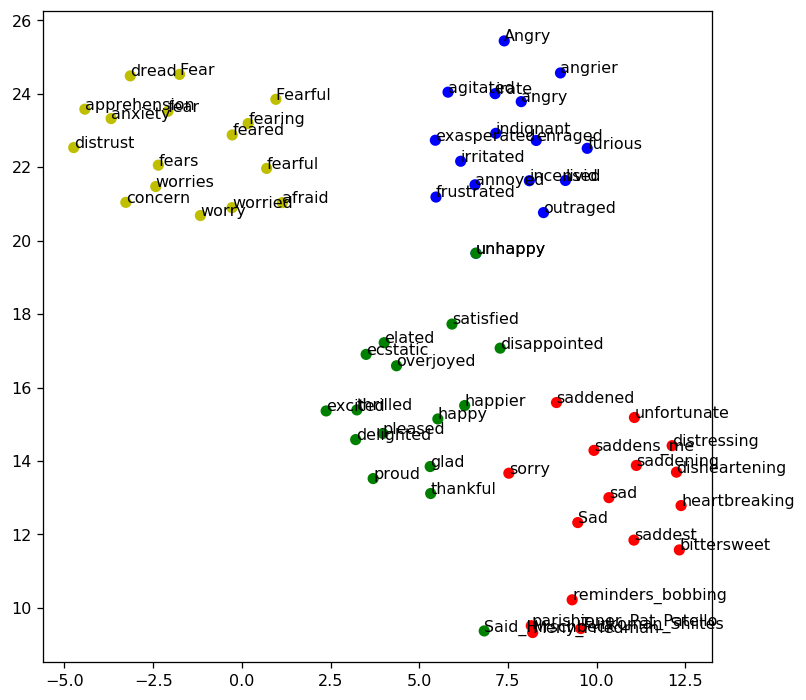

In [43]:
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.vocab.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
---
# Third part：Report of competition
---
---

### Preprocessing

In [ ]:
tkr = RegexpTokenizer('[a-zA-Z@]+')

tweets_split= []
stop_words= {'lh'}
for i, line in enumerate(tweets):
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_stop= []
    for j in tweet:
         if j not in stop_words:
              tweets_stop.append(j)
    tweets_split.append(tweets_stop)

"FOR TESTING DATA"
tweets_test_split= []
for i, line in enumerate(tweets_test):
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_test_stop= []
    for j in tweet:
         if j not in stop_words:
              tweets_test_stop.append(j)
    tweets_test_split.append(tweets_test_stop)

        I only using the twitter text from raw data for training, i did not consider the twitter hashtag.
        In this step, i remove stop word, punctuation, digit and change word to lower case.

### Feature engineering

In [ ]:
#Convert words to integers
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

        Takes each word in the text and replaces it with its corresponding integer value from the word dictionary.

In [ ]:
#add padding
maxlentweet = 120
X = pad_sequences(X, maxlen=maxlentweet)

"FOR TESTING DATA"
X_test = tokenizer.texts_to_sequences(tweets_test_split)
X_test = pad_sequences(X_test, maxlen=maxlentweet)

        Padding the sentence to the same length 120, i have tried some different padding length such like 200 and 50, but length 120 has the better performance.

### Model

In [ ]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], 
                            weights=[w2vModel.syn0], input_length=X.shape[1])

        Create a embedding layer that using Google pretriained word2vec model's parameter. The output of this embedding layer will give us a nice sentence embedding.

In [ ]:
# Parameter

y_dim=8
num_filters=64 
filter_sizes=[7,8,9]
pool_padding='valid'
dropout=0.5
lstm_out = 200

# Structure

embed_input = Input(shape=(X.shape[1],))
x = embedding_layer(embed_input)
x = Bidirectional(LSTM(lstm_out,return_sequences=True))(x)

pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='causal', activation='relu')(x)
    conv = GlobalMaxPooling1D()(conv)           
    pooled_outputs.append(conv)     
merge = concatenate(pooled_outputs)

x = Dropout(dropout)(merge)
x = Dense(y_dim, activation='softmax')(x)

model = Model(inputs=embed_input,outputs=x)

model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.summary()

        1. model explaintion
        
        LSTM-CNN model consists of an initial LSTM layer which will receive the word embedding. LSTM layer is generating a new encoding for the original input. The output of the LSTM layer is then fed into a multi-scales convolution layer which will extract different scales of the features. Finally the convolution layer’s output will be pooled to a smaller dimension and then connect to the dropout layer, the dropout layer will make the model more easily to training, and it must added after the maxpooling layer, ultimately the network will connect to the fully connected layer for classify the sentence.

         2. different things you tried and insights you gained
        
        During the model training process I have notice that after trains about three or four epoch, the validation loss will start to rise. In order to solve this problem, I have added DROPOUT after the LSTM, and I have made EMBEDDING LAYER untrainable. The purpose of doing these is to simplify model and make the training easier, avoiding the overfitting. After changeing the structure, i actually find out that the training process become more stable, and it really can train more epoch untill the validation loss rising showup, but unfortunately, the acuuracy on KAGGLE did not getting better.
        
        I have also tired cnn-lstm, but the result did not as good as lstm-cnn, according to the result, lstm-cnn is better than cnn-lstm in this case.